In [1]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [2]:
# cuda를 쓸 수 있으면 cuda를 쓰고 안되면 cpu를 사용한다
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [3]:
# parameters 선언
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [4]:
# MNIST dataset를 사용한다
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [5]:
# 데이터셋으로 dataset loader를 생성한다
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [6]:
# nn layers

# fcn을 생성한다
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
# 활성화함수를 생성한다
relu = torch.nn.ReLU()
# 활성화함수를 사용하기 전에 적용해 출력값의 분포를 고르게 할 배치 정규화 레이어를 생성한다
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

# fcn을 생성한다
nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [7]:
# model. bn이 들어간 모델과 들어가지 못한 모델 둘다 생성한다
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [8]:
# define cost/loss & optimizer을 생성한다
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
# 두 모델에 적용할 옵티마이저를 각각 생성한다
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [9]:
# Save Losses and Accuracies every epoch
# We are going to plot them later

# bn을 사용한 모델과 사용하지 않은 모델을 학습시킨다
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)
        
        # X, Y를 가지고 두 모델에서 정전파, 역전파를 수행 후 그레디언트를 구하여 가중치를 업데이트 시킨다
        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()
    
    # 매 에포크마다 성능을 비교해본다
    with torch.no_grad(): # 그레디언트 트레킹을 막는다. 
        bn_model.eval()     # 배치 정규화는 학습을 할 때만 사용한다. 지금은 테스트를 하기 때문에 eval 모드로 바꿔 배치 정규화가 실행되지 않게 만든다.

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            # 학습용 데이터셋을 가지고 각 모델들에서 예측값을 뽑은 뒤 loss와 정확도를 저장한다
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()
        
        # 배치로 나눠 평균값을 구한다
        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # 에포크마다 구한 loss, 정확도를 저장한다
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item())) # item()은 딕셔너리에서 (key, value) 쌍을 얻을 때 사용한다

        # Test the model using test sets
        # 이번에는 테스트 데이터셋으로 테스트해본다. 앞서 학습용 데이터셋으로 성능을 테스트할 때와 같은 과정을 거친다
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        # 학습용 데이터셋으로 얻은 loss, 정확도를 저장한다
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.13410(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.18107(nn_acc:0.94)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.14616(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.19708(nn_acc:0.94)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09749(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17446(nn_acc:0.95)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.11976(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.20342(nn_acc:0.94)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.08966(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.16192(nn_acc:0.95)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.11119(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.20309(nn_acc:0.95)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07156(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.13422(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.09732(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17067(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [10]:
# 배치 정규화가 있는 모델이랑 없는 모델의 성능을 그래프를 통해 비교하기 위한 함수. 
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

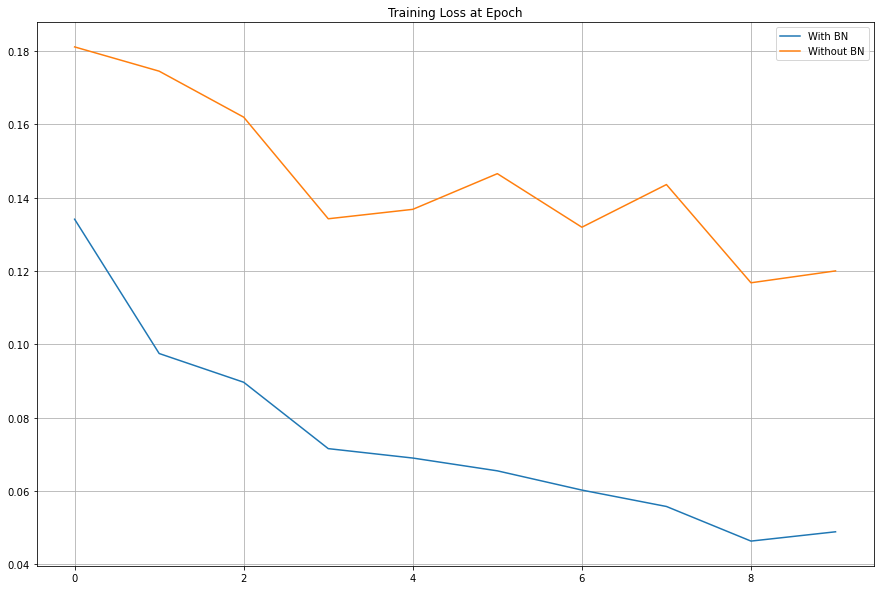

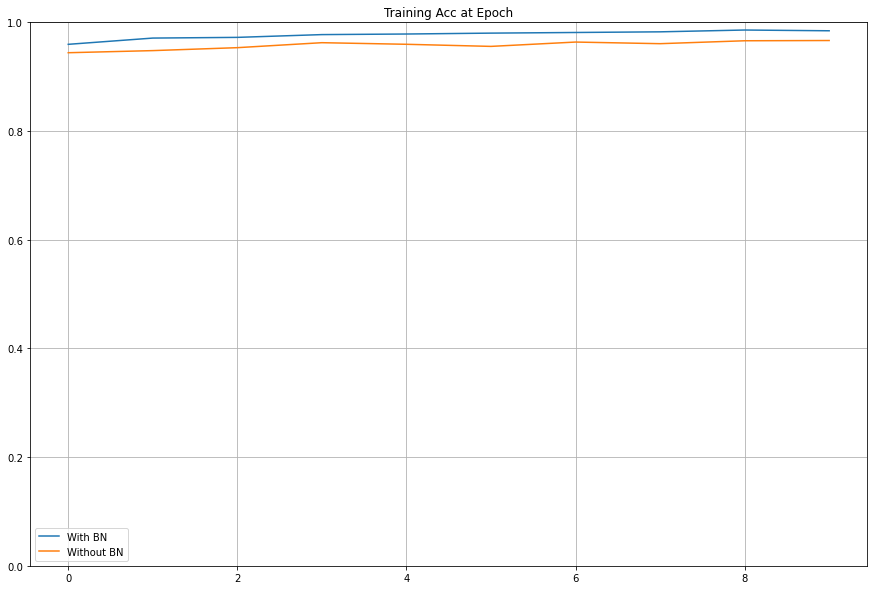

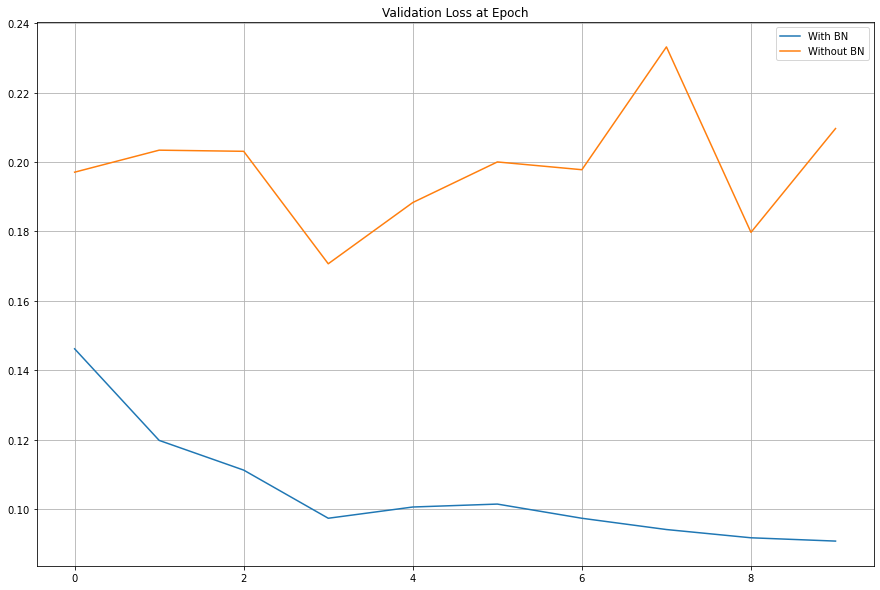

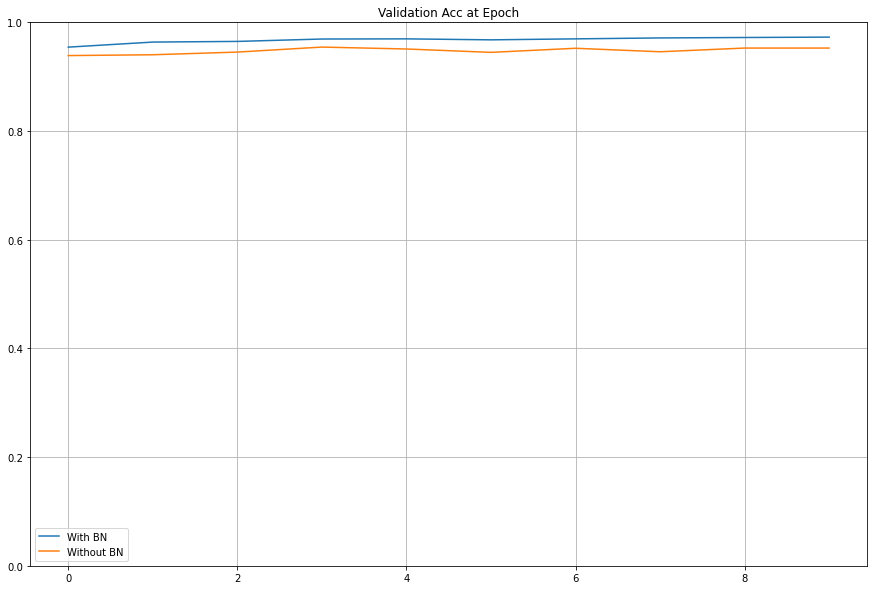

In [11]:
# 앞서 학습시킬 때 에포크당 loss, 정확도를 저장한 것을 여기에서 사용한다. 
# 배치 정규화가 있을 때 더 좋은 성능을 보여준다는 것을 확인할 수 있다. training loss, validation loss 모두 배치 정규화가 추가된 모델이 더 좋은 성능을 보여준다.
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')